# This notebook reproduces the results from:
Trevor Cohen* and Serguei Pakhomov*.  A Tale of Two Perplexities: Sensitivity of Neural Language Models to Lexical Retrieval Deficits in Dementia of the Alzheimer’s Type (* denotes equal contribution). To appear in Proceedings of the Annual Meeting of the Association for Computational Linguistics (ACL 2020), virtual conference, July 2020.


# Final results comparing performance of models +- interpolation and pretrained embeddings

In [1]:
# read in output files (10 runs with and without pre-trained embeddings)
# calculate AUC and accuracy at equal error rate
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
%matplotlib inline

aucframe = pd.DataFrame(columns = ['model','x_dementia','run','c','d','c-d AUC','c/d'])
eerframe = pd.DataFrame(columns = ['model','x_dementia','run','c','d','c-d ACC','c/d'])
counter = 0

#get auc from all models
for q in ['random','basic']:
    
    for c in range(1,11):
        #print(str(c)+'------------------------')
        auclist=[]
        eerlist=[]
        tempres=pd.read_csv('compare_interpolation/'+str(c)+'gluon_output_'+q+'.tmp', header=None, names=['label','control','d25','d50','d75','dementia','files'])
        tempres=tempres.dropna();
        ids=tempres['files'].replace(to_replace='-.*', value='',regex=True).replace(to_replace=' ', value='',regex=True)  
        tempres['id']=ids
        pf=tempres.groupby(['id']).mean()
        labels=pf['label']
        control=pf['control']
        d25=pf['d25']
        d50=pf['d50']
        d75=pf['d75']
        dementia=pf['dementia']
        labels=pf['label']
        k=['d25','d50','d75','dementia']
        #resframe = pd.DataFrame(columns = ['model','x_dementia','run','c','d','c-d','c/d'])


        for index,j in enumerate([d25,d50,d75,dementia]):
            auclist=[q]
            eerlist=[q]
            #print(k[index])
            auclist.append(k[index])
            auclist.append(c)
            eerlist.append(k[index])
            eerlist.append(c)
            for i in [['c',control],['d',j],['c-d',control-j],['c/d',control/j]]:
                fpr, tpr, thresholds = roc_curve(labels,i[1])
                roc_auc = auc(fpr, tpr)
                auclist.append(roc_auc)
                eerlist.append(tpr[np.nanargmax(np.absolute((tpr - fpr)))])
                #print(i[0],"\tAUC={:0.3f}".format(roc_auc), "\tACC={:0.3f}".format(tpr[np.nanargmax(np.absolute((tpr - fpr)))]))
            
            counter = counter + 1
            aucframe.loc[counter] = auclist
            eerframe.loc[counter] = eerlist

In [2]:
#stochastically initialized, AUC and accuracy at EER
aucframe_std = aucframe[aucframe['model']=='random'].groupby('x_dementia').agg([np.mean,np.std])
aucframe_std['c-d ci'] = (1.96*aucframe_std['c-d AUC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
eerframe_std = eerframe[eerframe['model']=='random'].groupby('x_dementia').agg([np.mean,np.std])
eerframe_std['c-d ci'] = (1.96*eerframe_std['c-d ACC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
comboframe=pd.concat([aucframe_std, eerframe_std], axis=1, sort=False)
print("STOCHASTICALLY INITIALIZED")
comboframe.iloc[:,np.r_[4,8,13,17]].round(3)

STOCHASTICALLY INITIALIZED


,c-d AUC,c-d ci,c-d ACC,c-d ci
,mean,,mean,
x_dementia,,,,
d25,0.842,0.008,0.689,0.036
d50,0.816,0.009,0.669,0.035
d75,0.931,0.003,0.854,0.031
dementia,0.908,0.004,0.846,0.023


In [3]:
#pretrained embeddings, AUC and accuracy at EER
aucframe_std = aucframe[aucframe['model']=='basic'].groupby('x_dementia').agg([np.mean,np.std])
aucframe_std['c-d ci'] = (1.96*aucframe_std['c-d AUC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
eerframe_std = eerframe[eerframe['model']=='basic'].groupby('x_dementia').agg([np.mean,np.std])
eerframe_std['c-d ci'] = (1.96*eerframe_std['c-d ACC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
comboframe=pd.concat([aucframe_std, eerframe_std], axis=1, sort=False)
print("PRETRAINED WORD EMBEDDINGS")
comboframe.iloc[:,np.r_[4,8,13,17]].round(3)

PRETRAINED WORD EMBEDDINGS


,c-d AUC,c-d ci,c-d ACC,c-d ci
,mean,,mean,
x_dementia,,,,
d25,0.838,0.015,0.724,0.034
d50,0.813,0.005,0.665,0.033
d75,0.941,0.006,0.872,0.010
dementia,0.930,0.005,0.839,0.017


# Paired perplexity of 'control' and 'dementia' models in relation to synthetic transcripts

In [17]:
#evaluate perplexities for synthetic transcripts (from first LOOCV run)
birdframe = pd.read_csv('compare_interpolation/1bird_output_random.tmp',header=None, names=['file','control','d25','d50','d75','dementia'])

In [18]:
bframe = birdframe.groupby('file').mean()
berrframe = birdframe.groupby('file').std()

In [19]:
bframe.head()

,control,d25,d50,d75,dementia
file,,,,,
mct_1_0.txt,52.537985,53.344787,171.183890,86.123216,85.610736
mct_1_5.txt,88.700744,75.057326,190.769023,105.989855,115.387488
mct_2_0.txt,129.868641,98.160491,213.240311,125.639616,148.459498
mct_2_5.txt,182.741229,119.104145,209.136780,122.683951,153.127117
mct_3_0.txt,404.991195,225.246773,302.464378,211.852153,310.039882


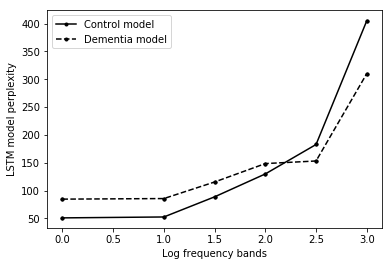

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#thanks to http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html
from cycler import cycler
# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':', '=.']) * cycler('marker', ['.','.', '^']))

bframe = birdframe.groupby('file').mean()
desired_columns = [0,1,1.5,2,2.5,3]
# Plot
fig, ax = plt.subplots()
ax.set_prop_cycle(monochrome)

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
plt.plot(desired_columns,bframe['control'].values[[5,0,1,2,3,4]],label='Control model')
plt.plot(desired_columns,bframe['dementia'].values[[5,0,1,2,3,4]],label='Dementia model', linestyle='dashed')
plt.errorbar(desired_columns,bframe['control'].values[[5,0,1,2,3,4]], yerr=berrframe['control'].values[[5,0,1,2,3,4]]/np.sqrt(2680), fmt='.k');
plt.errorbar(desired_columns,bframe['dementia'].values[[5,0,1,2,3,4]], yerr=berrframe['dementia'].values[[5,0,1,2,3,4]]/np.sqrt(2680), fmt='.k');
    
ax.legend(fontsize='10')#loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xticks(np.arange(0, 3)) 
plt.ylabel('LSTM model perplexity')
plt.xlabel('Log frequency bands')
plt.show()

# Interpolated models + synthetic transcripts

In [22]:
import scipy
bresframe = pd.DataFrame(columns=['xdementia','1','1.5','2','2.5','3','0'])
berrframe = pd.DataFrame(columns=['xdementia','1','1.5','2','2.5','3','0'])

birdmeans = birdframe.groupby('file').agg([np.mean])
birderrs = birdframe.groupby('file').agg([np.std])

# iterating the columns 
counter = 0

for it,col in enumerate(birdmeans.columns): 
    reslist = [counter*.25]
    for bm in birdmeans[col]:
        reslist.append(bm - np.min(birdmeans[col]))
    bresframe.loc[counter] = reslist
    counter = counter + 1
    
counter = 0

for it,col in enumerate(birderrs.columns): 
    reslist = [counter*.25]
    for em in birderrs[col]:
        reslist.append(em)
    berrframe.loc[counter] = reslist
    counter = counter + 1

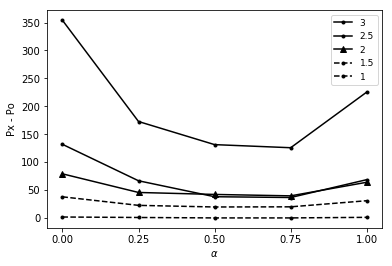

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#thanks to http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html

desired_columns = ['3','2.5','2','1.5','1']
# Plot
fig, ax = plt.subplots()
ax.set_prop_cycle(monochrome)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for b in desired_columns:
    #ax.scatter(bresframe['xdementia'],bresframe[b])
    #plt.errorbar(bresframe['xdementia'],bresframe[b], yerr=berrframe[b] / np.sqrt(2680), fmt='.k');
    plt.plot(bresframe['xdementia'],bresframe[b])

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize='9',bbox_to_anchor=(1, 1))
plt.xticks(np.arange(0, 1.1, 0.25)) 
plt.ylabel('Px - Po')
plt.xlabel('$\\alpha$')#'% Dementia LM')
plt.show()
#mixframe.plot(kind='scatter',x='xdementia',y='perplexity')

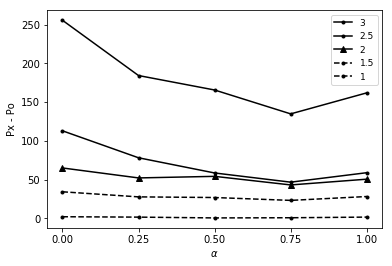

In [25]:
#same analysis with pretrained embeddings (not in paper)
#add perplexities for synthetic transcripts
birdframe = pd.read_csv('compare_interpolation/1bird_output_basic.tmp',header=None, names=['file','control','d25','d50','d75','dementia'])

bresframe = pd.DataFrame(columns=['xdementia','1','1.5','2','2.5','3','0'])
berrframe = pd.DataFrame(columns=['xdementia','1','1.5','2','2.5','3','0'])

birdmeans = birdframe.groupby('file').agg([np.mean])
birderrs = birdframe.groupby('file').agg([np.std])

# iterating the columns 
counter = 0

for it,col in enumerate(birdmeans.columns): 
    reslist = [counter*.25]
    for bm in birdmeans[col]:
        reslist.append(bm - np.min(birdmeans[col]))
    bresframe.loc[counter] = reslist
    counter = counter + 1
    
counter = 0

for it,col in enumerate(birderrs.columns): 
    reslist = [counter*.25]
    for em in birderrs[col]:
        reslist.append(em)
    berrframe.loc[counter] = reslist
    counter = counter + 1

desired_columns = ['3','2.5','2','1.5','1']
# Plot
fig, ax = plt.subplots()
ax.set_prop_cycle(monochrome)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for b in desired_columns:
    #ax.scatter(bresframe['xdementia'],bresframe[b])
    #plt.errorbar(bresframe['xdementia'],bresframe[b], yerr=berrframe[b] / np.sqrt(2680), fmt='.k');
    plt.plot(bresframe['xdementia'],bresframe[b])

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize='9',bbox_to_anchor=(1, 1))

#ax.legend()
plt.xticks(np.arange(0, 1.1, 0.25)) 
plt.ylabel('Px - Po')
plt.xlabel('$\\alpha$')#'% Dementia LM')
plt.show()
#mixframe.plot(kind='scatter',x='xdementia',y='perplexity')



## Mean 'dementia' case perplexities of baseline, pretrained and interpreted models

In [68]:
import pandas as pd
d75 = []
dr  = []
dpt = []
dpt75 = []

for i in range(1,11):
    tempres_r=pd.read_csv('compare_interpolation/'+str(i)+'gluon_output_'+'random'+'.tmp', header=None, names=['label','control','d25','d50','d75','dementia','files'])
    tempres_b=pd.read_csv('compare_interpolation/'+str(i)+'gluon_output_'+'basic'+'.tmp', header=None, names=['label','control','d25','d50','d75','dementia','files'])
    dr.append(tempres_r[tempres_r.label ==1]['dementia'].mean())
    d75.append(tempres_r[tempres_r.label ==1]['d75'].mean())
    dpt.append(tempres_b[tempres_b.label ==1]['dementia'].mean())
    dpt75.append(tempres_b[tempres_b.label ==1]['d75'].mean())

In [69]:
import numpy as np
print('model','xp(dem)','+-','CI')
print('random',round(np.mean(dr),3),'+-',round(1.96*np.std(dr)/np.sqrt(10),3))
print('pretra',round(np.mean(dpt),3),'+-',round(1.96*np.std(dpt)/np.sqrt(10),3))
print('inte75',round(np.mean(d75),3),'+-',round(1.96*np.std(d75)/np.sqrt(10),3))
print('pret75',round(np.mean(dpt75),3),'+-',round(1.96*np.std(dpt75)/np.sqrt(10),3))

model xp(dem) +- CI
random 51.116 +- 0.815
pretra 44.829 +- 0.532
inte75 47.322 +- 0.322
pret75 47.649 +- 0.448


# Same analyses for mild dementia cases

In [25]:
f2mmse_frame = pd.read_csv('f2mmse.csv')

In [26]:
lv_frame=f2mmse_frame.sort_values(by='visit').groupby('id').last()
lv_frame['id'] = lv_frame.index.values

In [27]:
#Get MMSE scores
mmse_id_dict={}
for i, row in lv_frame.iterrows():
    candidate = row['mmse']
    mmse_id_dict.update({str(row.id) : candidate})
    
#Get MMSE scores
mmse_dict={}
for i, row in f2mmse_frame.iterrows():
    candidate = row['mmse']
    mmse_dict.update({str(row.files) : candidate})

In [28]:
#add the MMSE for a trancript
def add_mmse(tempres2):
    mmse_list = []
    miscount = 0
    for i, row in tempres2.iterrows():
        try:
            mmse_list.append(mmse_dict[row.files.strip()])
        except: 
            miscount = miscount +1
            #print(miscount,"No id for",'[',row.files,']')
            mmse_list.append(np.nan)

    tempres2['mmse'] = mmse_list
    return tempres2

In [41]:
#add the last recorded MMSE for a participant
def add_mmse2(tempres2):
    mmse_list = []
    miscount = 0
    for i, row in tempres2.iterrows():
        try:
            mmse_list.append(mmse_id_dict[row.files.strip()[0:3]])
        except: 
            miscount = miscount +1
            #print(miscount,"No id for",'[',row.files,']')
            mmse_list.append(np.nan)

    tempres2['mmse'] = mmse_list
    return tempres2.dropna()

In [42]:
#Perplexities of models for MMSE <=10
d75 = []
dr  = []
dpt = []
dpt75 = []

for i in range(1,11):
    tempres_r=add_mmse(pd.read_csv('compare_interpolation/'+str(i)+'gluon_output_'+'random'+'.tmp', header=None, names=['label','control','d25','d50','d75','dementia','files']))
    tempres_r=tempres_r[tempres_r.mmse <= 10]
    tempres_b=add_mmse(pd.read_csv('compare_interpolation/'+str(i)+'gluon_output_'+'basic'+'.tmp', header=None, names=['label','control','d25','d50','d75','dementia','files']))
    tempres_b=tempres_b[tempres_b.mmse <= 10]
    dr.append(tempres_r[tempres_r.label ==1]['dementia'].mean())
    d75.append(tempres_r[tempres_r.label ==1]['d75'].mean())
    dpt.append(tempres_b[tempres_b.label ==1]['dementia'].mean())
    dpt75.append(tempres_b[tempres_b.label ==1]['d75'].mean())

In [43]:
print('model','xp(dem)','+-','CI')
print('random',round(np.mean(dr),3),'+-',round(1.96*np.std(dr)/np.sqrt(10),3))
print('pretra',round(np.mean(dpt),3),'+-',round(1.96*np.std(dpt)/np.sqrt(10),3))
print('inte75',round(np.mean(d75),3),'+-',round(1.96*np.std(d75)/np.sqrt(10),3))
print('pret75',round(np.mean(dpt75),3),'+-',round(1.96*np.std(dpt75)/np.sqrt(10),3))

model xp(dem) +- CI
random 148.288 +- 7.691
pretra 121.86 +- 7.669
inte75 105.088 +- 3.477
pret75 112.895 +- 5.005


In [44]:
from scipy import stats
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
%matplotlib inline

lastmmse=True #classify as 'mild' on basis of last MMSE (per Fritsch), or use transcript-level MMSE if false

mmaucframe = pd.DataFrame(columns = ['model','x_dementia','run','c','d','c-d AUC','c/d'])
mmeerframe = pd.DataFrame(columns = ['model','x_dementia','run','c','d','c-d ACC','c/d'])
counter = 0

spears = []

#get auc from all models
for q in ['random','basic']:
    
    for c in range(1,11):
        #print(str(c)+'------------------------')
        tempres2=pd.read_csv('compare_interpolation/'+str(c)+'gluon_output_'+q+'.tmp', header=None, names=['label','control','d25','d50','d75','dementia','files'])
        #tempres2=tempres2.dropna();
        ids=tempres2['files'].replace(to_replace='-.*', value='',regex=True).replace(to_replace=' ', value='',regex=True)  
        vis=tempres2['files'].replace(to_replace='.*-', value='',regex=True).replace(to_replace=' ', value='',regex=True) 

        tempres2['id']=ids
        tempres2['vis']=vis
        tempres2=tempres2.dropna()
        
        mmse_list = []
        mmse_id_list = []
        miscount = 0
        for i, row in tempres2.iterrows():
            try:
                mmse_id_list.append(mmse_id_dict[row.id])
            except: 
                miscount = miscount +1
                #print(miscount,"No id for",'[',row.files,']')
                mmse_id_list.append(np.nan)
            try:
                mmse_list.append(mmse_dict[row.files.strip()])
            except: 
                miscount = miscount +1
                #print(miscount,"No id for",'[',row.files,']')
                mmse_list.append(np.nan)

        tempres2['mmse'] = mmse_list
        tempres2['mmseid'] = mmse_id_list
        
        #tempres2 = tempres2[tempres2['mmse'] >= 21]
        #tempres2 = tempres2[tempres2['vis'] == '0.txt']
        
        #pf_mild=tempres2.dropna().groupby(['id']).mean()
        pf_mild = tempres2.dropna()
        if lastmmse:
            pf_mild = pf_mild[pf_mild.mmseid >= 21]
            pf_mild = pf_mild.groupby(['id']).mean()
        else:
            pf_mild = pf_mild[pf_mild.mmse >= 21]
       #print(stats.spearmanr(tempres2['mmse'],tempres2['control']-tempres2['d75']))
        
        #pf_mild = tempres2.dropna()
        #print (len(pf_mild[pf_mild.label == 1]),len(tempres2[tempres2.label == 1]))
        
        auclist=[]
        eerlist=[]
        labels=pf_mild['label']
        #mmses=pf_mild['mmse']
        control=pf_mild['control']
        d25=pf_mild['d25']
        d50=pf_mild['d50']
        d75=pf_mild['d75']
        dementia=pf_mild['dementia']
        labels=pf_mild['label']
        k=['d25','d50','d75','dementia']
        #resframe = pd.DataFrame(columns = ['model','x_dementia','run','c','d','c-d','c/d'])

        for index,j in enumerate([d25,d50,d75,dementia]):
            auclist=[q]
            eerlist=[q]
            #print(k[index])
            auclist.append(k[index])
            auclist.append(c)
            eerlist.append(k[index])
            eerlist.append(c)
            for i in [['c',control],['d',j],['c-d',control-j],['c/d',control/j]]:
                fpr, tpr, thresholds = roc_curve(labels,i[1])
                roc_auc = auc(fpr, tpr)
                auclist.append(roc_auc)
                eerlist.append(tpr[np.nanargmax(np.absolute((tpr - fpr)))])
                #print(i[0],"\tAUC={:0.3f}".format(roc_auc), "\tACC={:0.3f}".format(tpr[np.nanargmax(np.absolute((tpr - fpr)))]))
            
            counter = counter + 1
            mmaucframe.loc[counter] = auclist
            mmeerframe.loc[counter] = eerlist

In [45]:
#stochastically initialized, AUC and accuracy at EER
mmaucframe_std = mmaucframe[mmaucframe['model']=='random'].groupby('x_dementia').agg([np.mean,np.std])
mmaucframe_std['c-d ci'] = (1.96*mmaucframe_std['c-d AUC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
mmeerframe_std = mmeerframe[mmeerframe['model']=='random'].groupby('x_dementia').agg([np.mean,np.std])
mmeerframe_std['c-d ci'] = (1.96*mmeerframe_std['c-d ACC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
comboframe=pd.concat([mmaucframe_std, mmeerframe_std], axis=1, sort=False)
print("STOCHASTICALLY INITIALIZED")
comboframe.iloc[:,np.r_[4,8,13,17]].round(3)

STOCHASTICALLY INITIALIZED


,c-d AUC,c-d ci,c-d ACC,c-d ci
,mean,,mean,
x_dementia,,,,
d25,0.768,0.016,0.715,0.059
d50,0.746,0.022,0.606,0.042
d75,0.893,0.004,0.849,0.025
dementia,0.836,0.014,0.789,0.031


In [46]:
#stochastically initialized, AUC and accuracy at EER
mmaucframe_std = mmaucframe[mmaucframe['model']=='basic'].groupby('x_dementia').agg([np.mean,np.std])
mmaucframe_std['c-d ci'] = (1.96*mmaucframe_std['c-d AUC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
mmeerframe_std = mmeerframe[mmeerframe['model']=='basic'].groupby('x_dementia').agg([np.mean,np.std])
mmeerframe_std['c-d ci'] = (1.96*mmeerframe_std['c-d ACC']['std'] / np.sqrt(10)) #resframe_std['c/d']['mean'] - (1.96*resframe_std['c/d']['std'] / np.sqrt(10)) 
comboframe=pd.concat([mmaucframe_std, mmeerframe_std], axis=1, sort=False)
print("PRETRAINED EMBEDDINGS")
comboframe.iloc[:,np.r_[4,8,13,17]].round(3)

PRETRAINED EMBEDDINGS


,c-d AUC,c-d ci,c-d ACC,c-d ci
,mean,,mean,
x_dementia,,,,
d25,0.771,0.019,0.655,0.059
d50,0.730,0.015,0.572,0.066
d75,0.899,0.012,0.855,0.032
dementia,0.879,0.010,0.849,0.023
